In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [2]:
dataset = TUDataset(root="TUDataset", name="MUTAG")
dataset[1].x

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

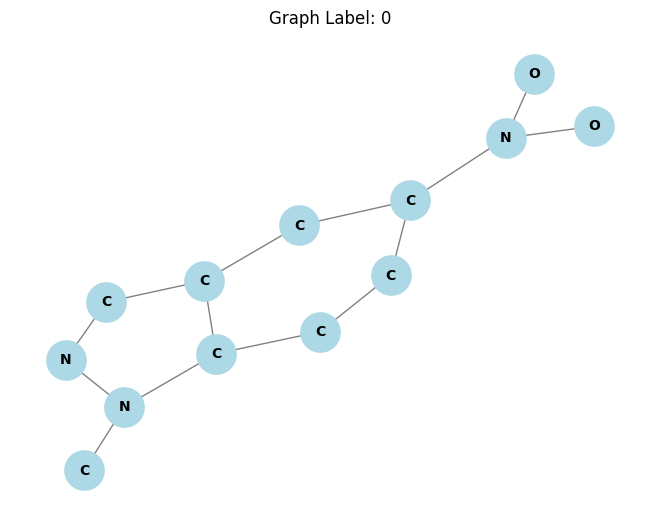

In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import random

data = random.choice(dataset)
G = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(G) 
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(data.x)}
nx.draw(G, pos, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=800, font_size=10, font_weight="bold")
# show label graph
y = data.y.item()
plt.title(f"Graph Label: {y}")
plt.show()

In [4]:
train_dataset, val_dataset, test_dataset = dataset[:150], dataset[150:169], dataset[169:]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training set   = 150 graphs
Validation set = 19 graphs
Test set       = 19 graphs


/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
import sys
import os

# Lấy đường dẫn thư mục gốc (project_root)
project_root = os.path.abspath(os.path.join(os.path.dirname('model'), ".."))
sys.path.append(project_root)

In [59]:
import torch
from torch_geometric.data import DataLoader
from model.gin import GIN

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GIN(
        in_channels=dataset.num_features,
        hidden_channels=32,
        out_channels=dataset.num_classes,
        num_layers=5,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#     # blackbox
# df = get_mean_node_embeddings_df(model,  device, test_loader)

In [60]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

In [61]:
import time
times = []
for epoch in range(1, 201):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 0.8850, Train: 0.6600, Test: 0.6316
Epoch: 002, Loss: 0.6239, Train: 0.6600, Test: 0.6316
Epoch: 003, Loss: 0.4349, Train: 0.6667, Test: 0.6316
Epoch: 004, Loss: 0.3911, Train: 0.6800, Test: 0.6316
Epoch: 005, Loss: 0.3869, Train: 0.7533, Test: 0.6842
Epoch: 006, Loss: 0.3503, Train: 0.7800, Test: 0.7368
Epoch: 007, Loss: 0.3126, Train: 0.8267, Test: 0.6842
Epoch: 008, Loss: 0.3508, Train: 0.3467, Test: 0.4211
Epoch: 009, Loss: 0.4007, Train: 0.7333, Test: 0.6316
Epoch: 010, Loss: 0.3085, Train: 0.7600, Test: 0.5789
Epoch: 011, Loss: 0.3464, Train: 0.7600, Test: 0.5789
Epoch: 012, Loss: 0.2650, Train: 0.8133, Test: 0.6842
Epoch: 013, Loss: 0.2760, Train: 0.9400, Test: 0.7895
Epoch: 014, Loss: 0.2930, Train: 0.8867, Test: 0.7895
Epoch: 015, Loss: 0.2568, Train: 0.8800, Test: 0.7368
Epoch: 016, Loss: 0.2586, Train: 0.7667, Test: 0.6842
Epoch: 017, Loss: 0.2655, Train: 0.8867, Test: 0.7895
Epoch: 018, Loss: 0.2475, Train: 0.9267, Test: 0.8421
Epoch: 019, Loss: 0.2459, Tr

In [9]:
from model.gin import prepare_dataframe
model.eval()

# blackbox
df = prepare_dataframe(dataset, model, device)

In [62]:
torch.save(model.state_dict(), '../model/model_mutag.pth')

In [ ]:
from genetic import *
from GA_graph import *

graphX = dataset[0]
populations = genetic_algorithm(graphX=graphX, populationSize=400, generations=10, 
                                blackbox= model, distance_function=compute_fgw_distance, alpha1=0.5, alpha2 = 0.5)
populations


===== sso : Generation 1/10 =====

===== sso : Generation 2/10 =====

===== sso : Generation 3/10 =====

===== sso : Generation 4/10 =====

===== sso : Generation 5/10 =====

===== sso : Generation 6/10 =====

===== sso : Generation 7/10 =====

===== sso : Generation 8/10 =====

===== sso : Generation 9/10 =====

===== sso : Generation 10/10 =====

===== sdo : Generation 1/10 =====

===== sdo : Generation 2/10 =====

===== sdo : Generation 3/10 =====

===== sdo : Generation 4/10 =====

===== sdo : Generation 5/10 =====

===== sdo : Generation 6/10 =====

===== sdo : Generation 7/10 =====

===== sdo : Generation 8/10 =====

===== sdo : Generation 9/10 =====

===== sdo : Generation 10/10 =====

===== dso : Generation 1/10 =====

===== dso : Generation 2/10 =====

===== dso : Generation 3/10 =====

===== dso : Generation 4/10 =====

===== dso : Generation 5/10 =====

===== dso : Generation 6/10 =====

===== dso : Generation 7/10 =====

===== dso : Generation 8/10 =====

===== dso : Gener

In [21]:
graphtest = random.choice(populations)
graphtest.x

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

Fitness: 0.5


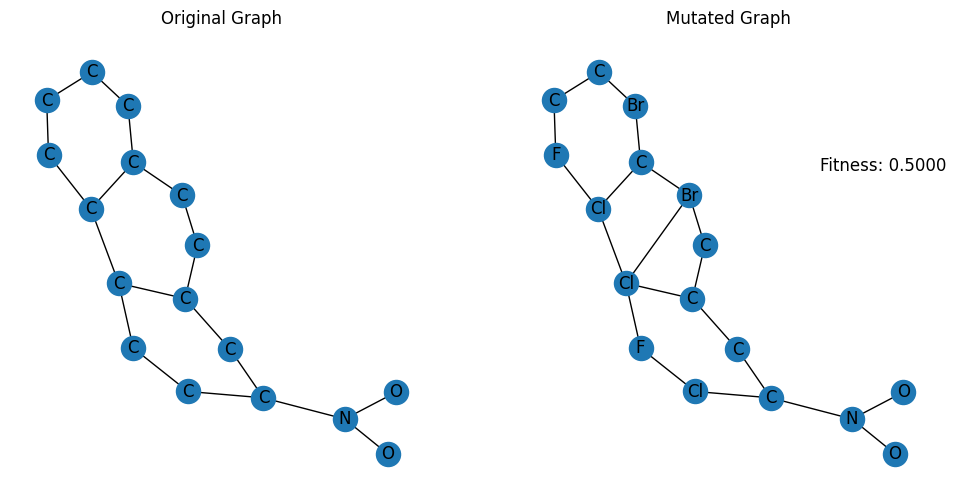

In [58]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

index = random.randint(0, len(populations) - 1)
print("Fitness:", populations[index].fitness)
graph_neig = Data(x=populations[index].x, edge_index=populations[index].edge_index)
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels_ori = {i: atom_types[x.argmax().item()] for i, x in enumerate(graphX.x)}
node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_neig.x)}
def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Graph")
G_original = to_networkx(graphX, to_undirected=True)
pos = layout(G_original)  
nx.draw(G_original, labels=node_labels_ori, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Mutated Graph")
plt.text(0.5, 0.5, "Fitness: {:.4f}".format(populations[index].fitness), fontsize=12)
G_mutated = to_networkx(graph_neig, to_undirected=True)
nx.draw(G_mutated, labels = node_labels, with_labels=True, pos=pos)
plt.show()

['blue', 'blue', 'green', 'blue', 'green', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'blue', 'green', 'blue']


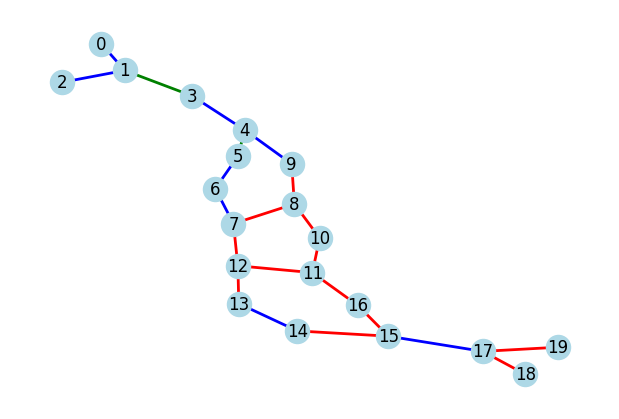

In [14]:
data = dataset[7]
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=True)

edge_attrs = data.edge_attr.argmax(dim=1).tolist() 

# Loai lien kết: 0: aromatic, 1: single, 2: double, 3: triple
edge_color_list = ['red', 'blue', 'green', 'grey']  
edge_colors = [edge_color_list[attr] for attr in edge_attrs]
print(edge_colors)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2)

plt.show()

In [37]:
import pandas as pd
import torch
import numpy as np

def create_adjacency_matrix(edge_index, num_nodes):
    """Create an adjacency matrix from edge indices."""
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
    if edge_index.numel() > 0:  # Check if there are any edges
        for i in range(edge_index.size(1)):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            adj_matrix[src, dst] = 1
            adj_matrix[dst, src] = 1  # Ensure undirected graph
    return adj_matrix

def prepare_dataframe(list_graph, model, device, predict = False):
    all_embeddings = []
    edge_dicts = []
    labels = []
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for graph in list_graph:
            x = graph.x.to(device)
            edge_index = ensure_undirected(graph.edge_index).to(device)

            _, node_embeddings = model(x, edge_index, None, 1, return_embeddings=True)

            mean_node_embedding = node_embeddings.mean(dim=1).cpu().numpy()
            all_embeddings.append(mean_node_embedding.tolist())
            
            num_nodes = graph.num_nodes
            adj_matrix = create_adjacency_matrix(graph.edge_index.cpu(), num_nodes)
            
            # Convert adjacency matrix to dictionary
            edge_dict = {f'n{r}_n{c}': adj_matrix[r, c].item() 
                         for r in range(num_nodes) for c in range(r, num_nodes)}
            edge_dicts.append(edge_dict)
            
            if predict:
                labels.append(graph.y.item())
            else :
                prediction = model.predict(x, edge_index, None, 1)
                labels.append(prediction.item())
                
    
    # Create DataFrame
    max_embed_dim = max(len(embed) for embed in all_embeddings)
    embed_columns = [f'nE_{i+1}' for i in range(max_embed_dim)]
    df_embeddings = pd.DataFrame(all_embeddings, columns=embed_columns)
    
    # Create DataFrame for edge information
    df_edges = pd.DataFrame(edge_dicts).fillna(0).astype(int)
    
    # Combine DataFrames
    result_df = pd.concat([df_embeddings, df_edges], axis=1)
    result_df['y'] = labels
    
    return result_df

# Usage example
# Assuming you have already run the genetic algorithm and have final_population

df = prepare_dataframe(populations, model, device)
# count number of row has y = 1
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0


(213, 187)